In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


C:\Users\nagas\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\nagas\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Load a smaller subset of the training data for quicker iterations
train_data = pd.read_csv('train2.csv').sample(frac=0.1, random_state=42)

# Load the test data
test_data = pd.read_csv('test.csv')

# Check for missing values
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()
print("Missing values in training data:\n", missing_values_train)
print("Missing values in test data:\n", missing_values_test)


Missing values in training data:
 tweets    0
class     0
dtype: int64
Missing values in test data:
 tweets    0
class     1
dtype: int64


Class distribution in training data:
 class
sarcasm    2018
regular    1910
Name: count, dtype: int64


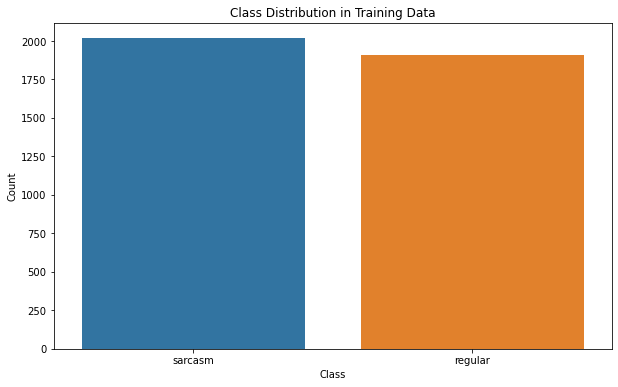

In [3]:
# Analyze the distribution of the classes
class_distribution = train_data['class'].value_counts()
print("Class distribution in training data:\n", class_distribution)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Tweet length stats:
 count    3928.000000
mean      102.840631
std        30.783232
min        20.000000
25%        79.000000
50%       108.000000
75%       132.000000
max       147.000000
Name: tweet_length, dtype: float64


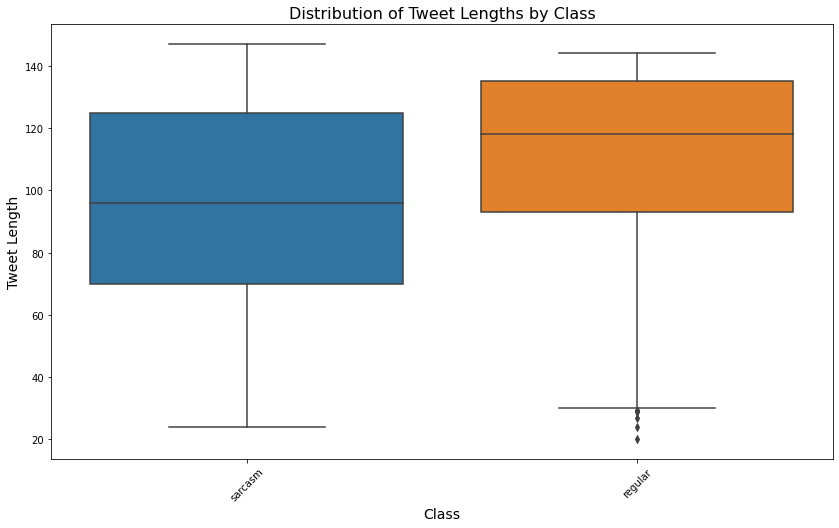

In [4]:
# Calculate the length of each tweet
train_data['tweet_length'] = train_data['tweets'].apply(len)
tweet_length_stats = train_data['tweet_length'].describe()
print("Tweet length stats:\n", tweet_length_stats)

# Plot tweet length distribution by class
plt.figure(figsize=(14, 8))
sns.boxplot(x='class', y='tweet_length', data=train_data)
plt.title('Distribution of Tweet Lengths by Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Tweet Length', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [5]:
# Preprocess the text
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+|www\S+|@\w+|#\w+|[^A-Za-z0-9\s]', '', text)
        text = text.lower()
    else:
        text = ""
    return text
train_data['clean_tweets'] = train_data['tweets'].apply(preprocess_text)
test_data['clean_tweets'] = test_data['tweets'].apply(preprocess_text)

# Combine all tweets into a single string for word frequency
all_words = ' '.join(train_data['clean_tweets'])
word_freq = Counter(all_words.split())

# Display the 10 most common words
common_words = word_freq.most_common(10)
print("Most common words:\n", common_words)

Most common words:
 [('the', 1343), ('to', 1081), ('a', 879), ('i', 661), ('of', 625), ('is', 584), ('in', 580), ('and', 558), ('for', 542), ('you', 509)]


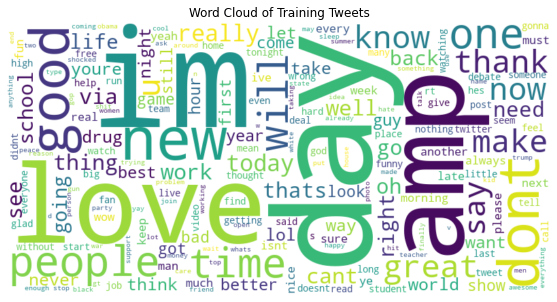

In [6]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Training Tweets')
plt.axis('off')
plt.show()

In [7]:
# Label sarcasm as 1 and others as 0
train_data['binary_class'] = train_data['class'].apply(lambda x: 1 if x == 'sarcasm' else 0)
test_data['binary_class'] = test_data['class'].apply(lambda x: 1 if x == 'sarcasm' else 0)

# Split data into training and testing sets
X_train = train_data['clean_tweets']
y_train = train_data['binary_class']
X_test = test_data['clean_tweets']
y_test = test_data['binary_class']


In [8]:
# Define the pipeline for Logistic Regression
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),  # Reduced features for speed
    ('clf', LogisticRegression(max_iter=100))
])
pipeline_lr

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('clf', LogisticRegression())])

In [9]:
# Define the pipeline for SVM
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),  # Reduced features for speed
    ('clf', SVC())
])
pipeline_svm

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)), ('clf', SVC())])

In [10]:
# Train and evaluate Logistic Regression
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

# Train and evaluate SVM
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      1860
           1       0.76      0.81      0.78      2105

    accuracy                           0.76      3965
   macro avg       0.76      0.76      0.76      3965
weighted avg       0.76      0.76      0.76      3965

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.70      0.74      1860
           1       0.76      0.84      0.80      2105

    accuracy                           0.77      3965
   macro avg       0.78      0.77      0.77      3965
weighted avg       0.77      0.77      0.77      3965



In [11]:
# Evaluation Function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")


In [17]:
# Evaluate Logistic Regression
print("Logistic Regression Performance:")
evaluate_model(y_test, y_pred_lr)

# Evaluate SVM
print("SVM Performance:")
evaluate_model(y_test, y_pred_svm)


Logistic Regression Performance:
Accuracy: 0.7644388398486759
Precision: 0.763382816014395
Recall: 0.8061757719714965
F1 Score: 0.7841959334565619
SVM Performance:
Accuracy: 0.7730138713745272
Precision: 0.7595863851788023
Recall: 0.8375296912114014
F1 Score: 0.7966561229100768


In [18]:
# Hyperparameter tuning for Logistic Regression with GridSearchCV
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1)  # Reduced cv for speed
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

In [19]:
# Hyperparameter tuning for SVM with GridSearchCV
param_grid_svm = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring='f1', n_jobs=-1)  # Reduced cv for speed
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

In [20]:
# Evaluate Tuned Logistic Regression 
y_pred_lr_tuned = best_lr.predict(X_test)
print("Tuned Logistic Regression with SMOTE Classification Report:\n", classification_report(y_test, y_pred_lr_tuned))

# Evaluate Tuned SVM
y_pred_svm_tuned = best_svm.predict(X_test)
print("Tuned SVM with SMOTE Classification Report:\n", classification_report(y_test, y_pred_svm_tuned))

Tuned Logistic Regression with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.72      1860
           1       0.74      0.83      0.78      2105

    accuracy                           0.75      3965
   macro avg       0.76      0.75      0.75      3965
weighted avg       0.76      0.75      0.75      3965

Tuned SVM with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.70      0.74      1860
           1       0.76      0.84      0.80      2105

    accuracy                           0.77      3965
   macro avg       0.78      0.77      0.77      3965
weighted avg       0.77      0.77      0.77      3965



In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Preprocess the text with additional steps
def advanced_preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+|www\S+|@\w+|#\w+|[^A-Za-z0-9\s]', '', text)
        text = text.lower()
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    else:
        text = ""
    return text

train_data['clean_tweets'] = train_data['tweets'].apply(advanced_preprocess_text)
test_data['clean_tweets'] = test_data['tweets'].apply(advanced_preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
from gensim.models import Word2Vec

# Tokenize the tweets
train_data['tokenized_tweets'] = train_data['clean_tweets'].apply(lambda x: x.split())
test_data['tokenized_tweets'] = test_data['clean_tweets'].apply(lambda x: x.split())

# Train Word2Vec model on the training data
word2vec_model = Word2Vec(sentences=train_data['tokenized_tweets'], vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")


In [23]:
# Load the model
word2vec_model = Word2Vec.load("word2vec.model")

# Function to create word embeddings
def get_word2vec_embeddings(text, model):
    embeddings = np.zeros(100)
    for word in text:
        if word in model.wv.key_to_index:
            embeddings += model.wv[word]
    return embeddings

train_data['word2vec_embeddings'] = train_data['tokenized_tweets'].apply(lambda x: get_word2vec_embeddings(x, word2vec_model))
test_data['word2vec_embeddings'] = test_data['tokenized_tweets'].apply(lambda x: get_word2vec_embeddings(x, word2vec_model))


In [24]:
# Prepare the data for training
X_train_embeddings = np.stack(train_data['word2vec_embeddings'].values)
X_test_embeddings = np.stack(test_data['word2vec_embeddings'].values)

In [25]:
from sklearn.ensemble import VotingClassifier

# Define the individual models
lr = LogisticRegression(max_iter=100)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(probability=True)

# Combine models into an ensemble
ensemble = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('svm', svm)], voting='soft')


In [26]:
# Train the ensemble
ensemble.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred_ensemble = ensemble.predict(X_test_embeddings)
print("Ensemble Model Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65      1860
           1       0.70      0.68      0.69      2105

    accuracy                           0.67      3965
   macro avg       0.67      0.67      0.67      3965
weighted avg       0.67      0.67      0.67      3965



In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [28]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['clean_tweets'])

X_train_seq = tokenizer.texts_to_sequences(train_data['clean_tweets'])
X_test_seq = tokenizer.texts_to_sequences(test_data['clean_tweets'])


In [29]:
# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=50)
X_test_padded = pad_sequences(X_test_seq, maxlen=50)

In [30]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=50))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [31]:
 # Train the model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/5
56/56 [==============================] - 10s 105ms/step - loss: 0.6781 - accuracy: 0.5723 - val_loss: 0.6459 - val_accuracy: 0.6387
Epoch 2/5
56/56 [==============================] - 5s 90ms/step - loss: 0.5015 - accuracy: 0.7737 - val_loss: 0.6014 - val_accuracy: 0.7176
Epoch 3/5
56/56 [==============================] - 5s 90ms/step - loss: 0.3062 - accuracy: 0.8662 - val_loss: 0.6888 - val_accuracy: 0.6921
Epoch 4/5
56/56 [==============================] - 5s 92ms/step - loss: 0.2106 - accuracy: 0.9174 - val_loss: 0.8428 - val_accuracy: 0.6870
Epoch 5/5
56/56 [==============================] - 5s 91ms/step - loss: 0.1585 - accuracy: 0.9403 - val_loss: 0.9166 - val_accuracy: 0.6921


In [32]:
# Evaluate the model
y_pred_lstm = (model.predict(X_test_padded) > 0.5).astype("int32")
print("LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm))

124/124 [==============================] - 2s 12ms/step
LSTM Model Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70      1860
           1       0.74      0.73      0.73      2105

    accuracy                           0.72      3965
   macro avg       0.72      0.72      0.72      3965
weighted avg       0.72      0.72      0.72      3965



In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [34]:
# Define the model creation function for KerasClassifier
def create_lstm_model(optimizer='adam', dropout_rate=0.2, lstm_units=100):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=100, input_length=50))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# Wrap the model with KerasClassifier and set the parameters
model = KerasClassifier(
    model=create_lstm_model,
    verbose=1,
    optimizer='adam',
    dropout_rate=0.2,
    lstm_units=100,
    epochs=5,
    batch_size=64
)

In [35]:
# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'lstm_units': [50, 100, 150],
    'epochs': [5, 10],
    'batch_size': [32, 64, 128]
}
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_result = random_search.fit(X_train_padded, y_train)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/5
123/123 [==============================] - 11s 62ms/step - loss: 0.6733 - accuracy: 0.5942
Epoch 2/5
123/123 [==============================] - 8s 61ms/step - loss: 0.4875 - accuracy: 0.7785
Epoch 3/5
123/123 [==============================] - 8s 62ms/step - loss: 0.3467 - accuracy: 0.8490
Epoch 4/5
123/123 [==============================] - 8s 63ms/step - loss: 0.2667 - accuracy: 0.8936
Epoch 5/5
123/123 [==============================] - 8s 62ms/step - loss: 0.2175 - accuracy: 0.9114


In [36]:
# Get the best model
best_model = random_search_result.best_estimator_

In [37]:
# Evaluate the best model
y_pred_lstm_tuned = (best_model.predict(X_test_padded) > 0.5).astype("int32")
print("Tuned LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm_tuned))

124/124 [==============================] - 2s 12ms/step
Tuned LSTM Model Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70      1860
           1       0.74      0.74      0.74      2105

    accuracy                           0.72      3965
   macro avg       0.72      0.72      0.72      3965
weighted avg       0.72      0.72      0.72      3965



In [38]:
import pandas as pd
import random
from nltk.corpus import wordnet, stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nagas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
# Define a function for synonym replacement
def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: 
            break

    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return list(set(synonyms))

# Augment the minority class
augmented_texts = []
for text in train_data[train_data['binary_class'] == 1]['clean_tweets']:
    augmented_texts.append(synonym_replacement(text, 1))
    augmented_texts.append(synonym_replacement(text, 2))


In [40]:
# Add augmented texts to the training data
augmented_df = pd.DataFrame({'clean_tweets': augmented_texts, 'binary_class': 1})
train_data_augmented = pd.concat([train_data, augmented_df])

# Prepare the data for training again
X_train_augmented = train_data_augmented['clean_tweets']
y_train_augmented = train_data_augmented['binary_class']


In [41]:
# Tokenize and pad the sequences
X_train_seq_augmented = tokenizer.texts_to_sequences(X_train_augmented)
X_train_padded_augmented = pad_sequences(X_train_seq_augmented, maxlen=50)

In [42]:
 from tensorflow.keras.models import load_model

# Define another LSTM model with a different configuration
def create_lstm_model_2(optimizer='adam', dropout_rate=0.2, lstm_units=100):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=100, input_length=50))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [43]:
# Train the first LSTM model
model_1 = create_lstm_model()
model_1.fit(X_train_padded_augmented, y_train_augmented, epochs=5, batch_size=64, validation_split=0.1)
model_1.save("model_1.h5")

# Train the second LSTM model
model_2 = create_lstm_model_2()
model_2.fit(X_train_padded_augmented, y_train_augmented, epochs=5, batch_size=64, validation_split=0.1)
model_2.save("model_2.h5")

Epoch 1/5
112/112 [==============================] - 15s 103ms/step - loss: 0.5495 - accuracy: 0.7370 - val_loss: 0.2478 - val_accuracy: 0.9975
Epoch 2/5
112/112 [==============================] - 12s 111ms/step - loss: 0.3263 - accuracy: 0.8679 - val_loss: 0.2698 - val_accuracy: 0.9021
Epoch 3/5
112/112 [==============================] - 13s 113ms/step - loss: 0.2056 - accuracy: 0.9181 - val_loss: 0.2398 - val_accuracy: 0.9059
Epoch 4/5
112/112 [==============================] - 13s 116ms/step - loss: 0.1549 - accuracy: 0.9386 - val_loss: 0.2377 - val_accuracy: 0.9084
Epoch 5/5
112/112 [==============================] - 13s 119ms/step - loss: 0.1235 - accuracy: 0.9494 - val_loss: 0.1515 - val_accuracy: 0.9511
Epoch 1/5
112/112 [==============================] - 18s 131ms/step - loss: 0.5521 - accuracy: 0.7380 - val_loss: 0.2687 - val_accuracy: 0.9912
Epoch 2/5
112/112 [==============================] - 14s 123ms/step - loss: 0.3273 - accuracy: 0.8654 - val_loss: 0.2826 - val_accuracy:

In [44]:
# Load the models
model_1 = load_model("model_1.h5")
model_2 = load_model("model_2.h5")


In [45]:
# Combine predictions using majority voting
y_pred_model_1 = (model_1.predict(X_test_padded) > 0.5).astype("int32")
y_pred_model_2 = (model_2.predict(X_test_padded) > 0.5).astype("int32")

y_pred_ensemble = (y_pred_model_1 + y_pred_model_2) / 2
y_pred_ensemble = (y_pred_ensemble > 0.5).astype("int32")

print("Ensemble of LSTM Models Classification Report:\n", classification_report(y_test, y_pred_ensemble))

124/124 [==============================] - 2s 12ms/step
Ensemble of LSTM Models Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.61      0.65      1860
           1       0.69      0.77      0.73      2105

    accuracy                           0.69      3965
   macro avg       0.69      0.69      0.69      3965
weighted avg       0.69      0.69      0.69      3965



In [46]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
X_train_bert = bert_tokenizer(list(X_train), max_length=50, padding=True, truncation=True, return_tensors='tf')
X_test_bert = bert_tokenizer(list(X_test), max_length=50, padding=True, truncation=True, return_tensors='tf')


In [47]:
# Load the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [48]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length
max_length = 50

# Tokenize and encode sequences in the training set
X_train_bert = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Define the BERT-based model
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
cls_token = bert_output[:, 0, :]

output = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)
bert_classifier = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [49]:
history = bert_classifier.fit({'input_ids': X_train_bert['input_ids'], 'attention_mask': X_train_bert['attention_mask']},
                              y_train, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3
111/111 [==============================] - 1692s 15s/step - loss: 0.5118 - accuracy: 0.7511 - val_loss: 0.5745 - val_accuracy: 0.7455
Epoch 2/3
111/111 [==============================] - 1637s 15s/step - loss: 0.3509 - accuracy: 0.8518 - val_loss: 0.4559 - val_accuracy: 0.8066
Epoch 3/3
111/111 [==============================] - 1675s 15s/step - loss: 0.1836 - accuracy: 0.9313 - val_loss: 0.5927 - val_accuracy: 0.7786


In [50]:
from sklearn.metrics import classification_report

X_test_bert = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)


In [51]:
predictions = bert_classifier.predict({'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']})

# Convert predictions to binary labels
y_pred = (predictions > 0.5).astype(int)


124/124 [==============================] - 534s 4s/step


In [52]:
report = classification_report(y_test, y_pred, target_names=['class 0', 'class 1'])
print(report)

              precision    recall  f1-score   support

     class 0       0.80      0.82      0.81      1860
     class 1       0.84      0.82      0.83      2105

    accuracy                           0.82      3965
   macro avg       0.82      0.82      0.82      3965
weighted avg       0.82      0.82      0.82      3965

